In [97]:
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.3.0


In [29]:
base_dir = "face_mask/dataset"

train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')
valid_dir = os.path.join(base_dir, 'Validation')

train_mask_dir = os.path.join(train_dir, 'Mask')
train_nomask_dir = os.path.join(train_dir, 'Non Mask')

In [30]:
train_mask_names = os.listdir(train_mask_dir)
print(train_mask_names[:10])

train_nomask_names = os.listdir(train_nomask_dir)
print(train_nomask_names[:10])

['0003.jpg', '0006.jpg', '0018.jpg', '0019.jpg', '0022.jpg', '0027.jpg', '0029.jpg', '0037.jpg', '0040.jpg', '0042.jpg']
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '104.jpg', '105.jpg', '106.jpg', '107.jpg']


In [31]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
img_index = 0

Have you seen the differneces? aboyt the shown images?
Current image index is 16


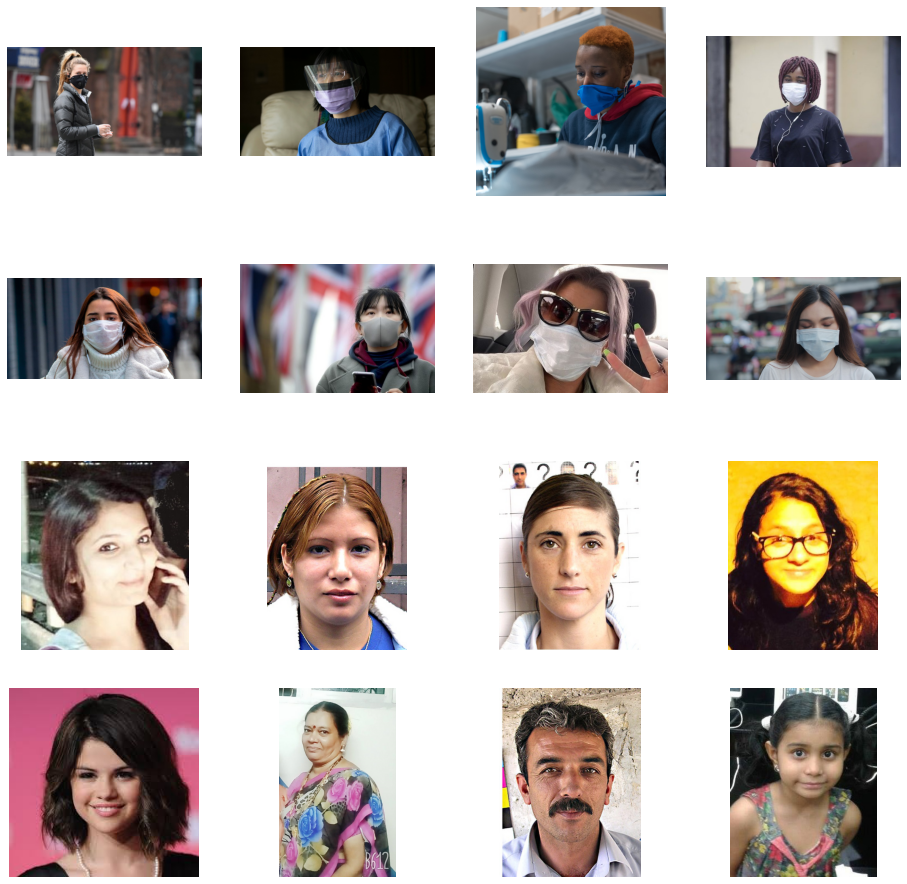

In [33]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

img_index += 8

print("Have you seen the differneces? aboyt the shown images?")
print("Current image index is {}".format(img_index))

next_normal_index = [os.path.join(train_mask_dir, fname)
                     for fname in train_mask_names[img_index-8: img_index]
                    ]

next_pneumonia_index = [os.path.join(train_nomask_dir, fname)
                        for fname in train_nomask_names[img_index-8: img_index]
                       ]

for i, img_path in enumerate(next_normal_index+next_pneumonia_index):
  
    # Set up subplot; subplot indices start at 1
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img, cmap = 'gray')

plt.show()

In [48]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=32,
                                                  class_mode='binary')

valid_generator = validation_datagen.flow_from_directory(valid_dir,
                                                         target_size=(150, 150),
                                                         batch_size=32,
                                                         class_mode='binary')

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [57]:
# Check train, test, and valid labels

print(train_generator.class_indices)
print(test_generator.class_indices)
print(valid_generator.class_indices)

{'Mask': 0, 'Non Mask': 1}
{'Mask': 0, 'Non Mask': 1}
{'Mask': 0, 'Non Mask': 1}


In [64]:
# Check input shape
print(train_generator.image_shape)
print(test_generator.image_shape)
print(valid_generator.image_shape)

(150, 150, 3)
(150, 150, 3)
(150, 150, 3)


In [67]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='SAME', activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Conv2D(64, (3, 3), padding='SAME', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Conv2D(128, (3, 3), padding='SAME', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Flatten(),
    
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 128)       7

In [76]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [77]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>0.95):
            print("\n Achieved 95% training accuracy so stop!")
            self.model.stop_training = True

# Instantiate it            
callbacks = mycallback()

In [78]:
history = model.fit(train_generator,
                    epochs = 30,
                    validation_data = valid_generator,
                    callbacks = [callbacks])

Epoch 1/30
19/19 [==============================] - 18s 956ms/step - loss: 0.6762 - accuracy: 0.5533 - val_loss: 0.6739 - val_accuracy: 0.5686
Epoch 2/30
19/19 [==============================] - 21s 1s/step - loss: 0.5014 - accuracy: 0.7617 - val_loss: 0.3837 - val_accuracy: 0.8562
Epoch 3/30
19/19 [==============================] - 21s 1s/step - loss: 0.3184 - accuracy: 0.8867 - val_loss: 0.2764 - val_accuracy: 0.9118
Epoch 4/30
19/19 [==============================] - 22s 1s/step - loss: 0.2813 - accuracy: 0.8967 - val_loss: 0.3078 - val_accuracy: 0.8824
Epoch 5/30
19/19 [==============================] - 20s 1s/step - loss: 0.2633 - accuracy: 0.9150 - val_loss: 0.3233 - val_accuracy: 0.8856
Epoch 6/30
19/19 [==============================] - 19s 1s/step - loss: 0.2373 - accuracy: 0.9117 - val_loss: 0.2441 - val_accuracy: 0.9052
Epoch 7/30
19/19 [==============================] - 20s 1s/step - loss: 0.2228 - accuracy: 0.9217 - val_loss: 0.2406 - val_accuracy: 0.9118
Epoch 8/30
19/19 

In [79]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [89]:
train_acc_list = history.history['accuracy']
train_loss_list = history.history['loss']
val_acc_list = history.history['val_accuracy']
val_loss_list = history.history['val_loss']

# Check 10 results
for i in range(10):
    print("Train Accuracy: {:.3f}, Train loss: {:.3f}".format(train_acc_list[i], train_loss_list[i]))

Train Accuracy: 0.553, Train loss: 0.676
Train Accuracy: 0.762, Train loss: 0.501
Train Accuracy: 0.887, Train loss: 0.318
Train Accuracy: 0.897, Train loss: 0.281
Train Accuracy: 0.915, Train loss: 0.263
Train Accuracy: 0.912, Train loss: 0.237
Train Accuracy: 0.922, Train loss: 0.223
Train Accuracy: 0.925, Train loss: 0.204
Train Accuracy: 0.917, Train loss: 0.231
Train Accuracy: 0.925, Train loss: 0.201


In [90]:
test_loss , test_acc = model.evaluate(test_generator)
print('test acc :{} test loss:{}'.format(test_acc,test_loss))

4/4 [==============================] - 2s 415ms/step - loss: 0.2073 - accuracy: 0.9100
test acc :0.9100000262260437 test loss:0.20729990303516388


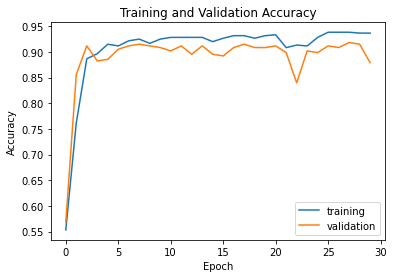

In [93]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

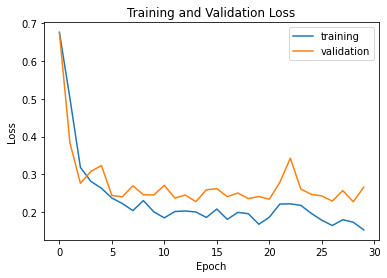

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

Test image: nomask_2.jpg
[[1.3238331e-14]]
<class 'numpy.ndarray'>
No Mask!!! Be careful~~~~~


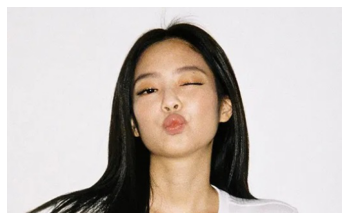

In [179]:
import numpy as np
from random import choice

from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.image as mpimg

test_img_path = "face_mask_test"
test_images = os.listdir(test_img_path)

picked_img = choice(test_images)
img = image.load_img(test_img_path+'/'+picked_img, target_size=(150, 150))

#print(test_img_path)
#print(show_img_path)
show_img_path = test_img_path + '/' + picked_img
#print(show_img_path)

show_img = mpimg.imread(show_img_path)

images = image.img_to_array(img)
images = np.expand_dims(images, axis=0)

print("Test image: {}".format(picked_img))
result = model.predict(images)
print(result)
print(type(result))

if result == 0:
    print("Mask. We're safe....")
else:
    print("No Mask!!! Be careful~~~~~")

plt.axis('Off')
plt.imshow(show_img)

In [174]:
model.save("face_mask_model.h5")